In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.segformer_simple import Segformerwithcarbon
from dataset_segwithcarbon import CarbonDataset, CarbonDataset_csv
from models.util import select_device, mix_patch
from tqdm import tqdm
from models.metrics import CarbonLoss , CarbonLossWithRMSE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.segformer_simple import Segformerwithcarbon
from models.unet import UNet_carbon

from dataset_segwithcarbon import CarbonDataset, CarbonDataset_csv
from models.util import select_device, mix_patch
from tqdm import tqdm
from models.metrics import CarbonLoss , CarbonLossWithRMSE
import os
import logging
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42)

def validate(model, device, loss_fn, loader, domain="Forest"):
    model.eval()
    val_stats = {'total_loss': 0.0, 'total_cls_loss': 0.0, 'total_reg_loss': 0.0,
                 'total_acc_c': 0.0, 'total_acc_r': 0.0, 'total_miou': 0.0, 'total_rmse': 0.0, 'batches': 0}
    
    with torch.no_grad():
        for x, carbon, gt in tqdm(loader, desc=f"Validating {domain}"):
            x, carbon, gt = x.to(device), carbon.to(device), gt.to(device)
            gt_pred, carbon_pred = model(x)
            total_loss, cls_loss, reg_loss, acc_c, acc_r, miou, rmse = loss_fn(gt_pred, gt.squeeze(1), carbon_pred, carbon)
            
            val_stats['total_loss'] += total_loss.item()
            val_stats['total_cls_loss'] += cls_loss.item()
            val_stats['total_reg_loss'] += reg_loss.item()
            val_stats['total_acc_c'] += acc_c
            val_stats['total_acc_r'] += acc_r
            val_stats['total_miou'] += miou
            val_stats['total_rmse'] += rmse
            val_stats['batches'] += 1

    return {k: v / val_stats['batches'] for k, v in val_stats.items() if k != 'batches'}

def get_transforms(label_size):
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    sh_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    label_transform = transforms.Compose([
        transforms.Resize((label_size, label_size)),
    ])
    return image_transform, sh_transform, label_transform

def get_transforms_baseline(label_size):
    image_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        
    ])
    sh_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    label_transform = transforms.Compose([
        transforms.Resize((label_size, label_size)),
    ])
    return image_transform, sh_transform, label_transform

def get_transforms_b0(label_size):
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    sh_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    label_transform = transforms.Compose([
        transforms.Resize((label_size, label_size)),
    ])
    return image_transform, sh_transform, label_transform

device = select_device()

In [5]:
forest_fp = "val_AP25_Forest_IMAGE.csv"
image_transform, sh_transform, label_transform = get_transforms_baseline(512)
baseline_forest_dataset = CarbonDataset_csv(forest_fp, image_transform, sh_transform, label_transform, mode="Valid",combine=True)
base_loader = DataLoader(baseline_forest_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

image_transform, sh_transform, label_transform = get_transforms_b0(64)
b0_forest_dataset = CarbonDataset_csv(forest_fp, image_transform, sh_transform, label_transform, mode="Valid",combine=True)
b0_loader = DataLoader(b0_forest_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

image_transform, sh_transform, label_transform = get_transforms(128)
ours_forest_dataset = CarbonDataset_csv(forest_fp, image_transform, sh_transform, label_transform, mode="Valid",combine=True)
ours_loader = DataLoader(ours_forest_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

In [6]:
clss_num = 4
def remove_profile_keys(state_dict):
    return {k: v for k, v in state_dict.items() if not k.endswith(('total_ops', 'total_params'))}

# 상태 사전 로드
state_dict = torch.load('checkpoints/Unet/UnetUnetAP25_Forest_256_best.pth', map_location=torch.device('cpu'))

# 프로파일링 키 제거
clean_state_dict = remove_profile_keys(state_dict)

baseline = UNet_carbon(num_classes=clss_num)

baseline.load_state_dict(clean_state_dict, strict=True)

baseline = baseline.to(device)

In [7]:
pretrain_path = "checkpoints\SegFomer\SegFomerB0AP25_Forest_64_best.pth"
def update_state_dict(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('to_segmentation.'):
            new_key = 'to_segmentation.to_segmentation.' + key[len('to_segmentation.'):]
            new_state_dict[new_key] = value
        elif key.startswith('to_regression.'):
            new_key = 'to_regression.to_regression.' + key[len('to_regression.'):]
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict
# 상태 사전 로드
state_dict = torch.load(pretrain_path,map_location=torch.device('cpu'))

model_args = {
    'dims': (32, 64, 160, 256),
    'heads': (1, 2, 5, 8),
    'ff_expansion': (8, 8, 4, 4),
    'reduction_ratio': (8, 4, 2, 1),
    'num_layers': 2,
    'decoder_dim': 256,
    'channels': 4,
    'num_classes': clss_num,
    'stage_kernel_stride_pad': [(7, 4, 3), (3, 2, 1), (3, 2, 1), (3, 2, 1)],
}

b0 = Segformerwithcarbon(**model_args)
b0.load_state_dict(state_dict,strict = True)
b0.to(device)


Segformerwithcarbon(
  (mit): MiT(
    (stages): ModuleList(
      (0): ModuleList(
        (0): Unfold(kernel_size=7, dilation=1, padding=3, stride=4)
        (1): Conv2d(196, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): ModuleList(
          (0-1): 2 x ModuleList(
            (0): PreNorm(
              (fn): EfficientSelfAttention(
                (to_q): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (to_kv): Conv2d(32, 64, kernel_size=(8, 8), stride=(8, 8), bias=False)
                (to_out): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              )
              (norm): LayerNorm()
            )
            (1): PreNorm(
              (fn): MixFeedForward(
                (net): Sequential(
                  (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
                  (1): DsConv2d(
                    (net): Sequential(
                      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [8]:
pretrain_path = "checkpoints\Segformerwithcarbon/first\SegformerwithcarbonB0AP25_Forest_128_best.pth"
def update_state_dict(state_dict):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith('to_segmentation.'):
            new_key = 'to_segmentation.to_segmentation.' + key[len('to_segmentation.'):]
            new_state_dict[new_key] = value
        elif key.startswith('to_regression.'):
            new_key = 'to_regression.to_regression.' + key[len('to_regression.'):]
            new_state_dict[new_key] = value
        else:
            new_state_dict[key] = value
    return new_state_dict

# 상태 사전 로드
state_dict = torch.load(pretrain_path,map_location=torch.device('cpu'))

# 상태 사전 업데이트
updated_state_dict = update_state_dict(state_dict)

model_args = {
    'dims': (32, 64, 160, 256),
    'heads': (1, 2, 5, 8),
    'ff_expansion': (8, 8, 4, 4),
    'reduction_ratio': (8, 4, 2, 1),
    'num_layers': (2, 2, 6, 3),
    'decoder_dim': 256,
    'channels': 4,
    'num_classes': clss_num,
    'stage_kernel_stride_pad': [(4, 2, 1), (3, 2, 1), (3, 2, 1), (3, 2, 1)],
}

ours = Segformerwithcarbon(**model_args)
ours.load_state_dict(updated_state_dict,strict = True)
ours.to(device)

Segformerwithcarbon(
  (mit): MiT(
    (stages): ModuleList(
      (0): ModuleList(
        (0): Unfold(kernel_size=4, dilation=1, padding=1, stride=2)
        (1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): ModuleList(
          (0-1): 2 x ModuleList(
            (0): PreNorm(
              (fn): EfficientSelfAttention(
                (to_q): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (to_kv): Conv2d(32, 64, kernel_size=(8, 8), stride=(8, 8), bias=False)
                (to_out): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              )
              (norm): LayerNorm()
            )
            (1): PreNorm(
              (fn): MixFeedForward(
                (net): Sequential(
                  (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
                  (1): DsConv2d(
                    (net): Sequential(
                      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

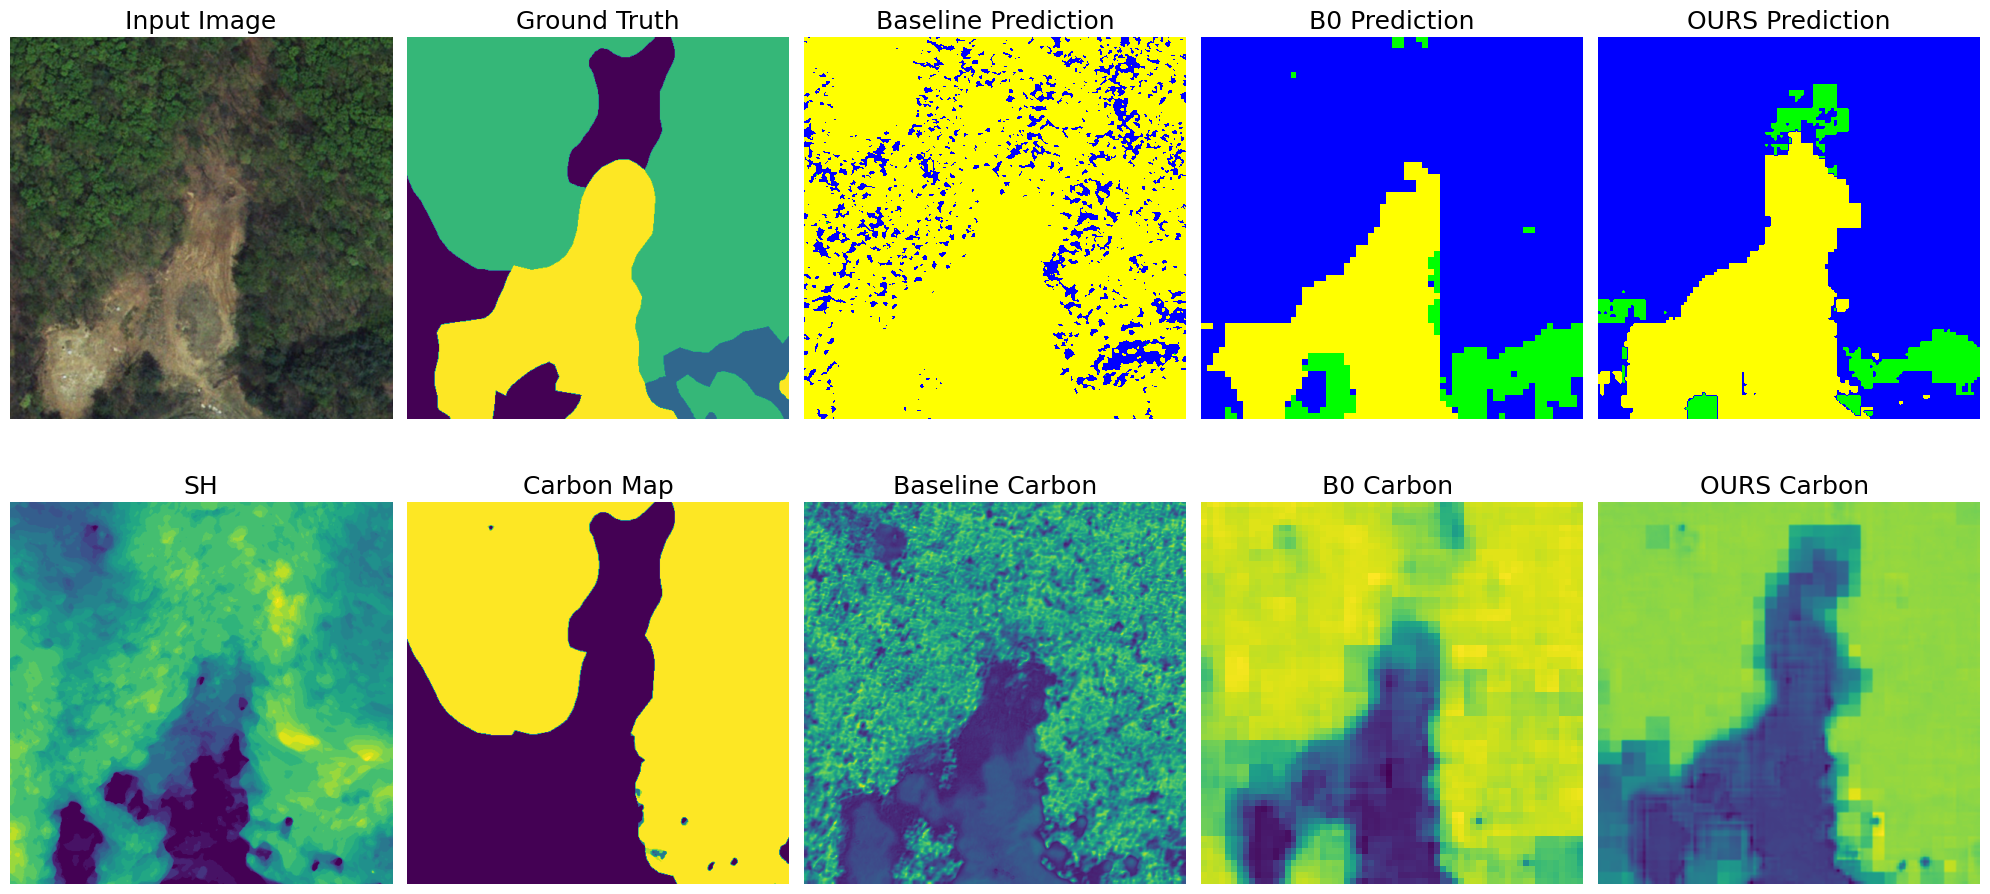

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Usage
# Assuming model1, model2, model3 are your models and dataloader1, dataloader2, dataloader3 are your dataloaders
model_dataset_pairs = [(baseline, base_loader), (b0, b0_loader), (ours, ours_loader)]


# 정규화된 이미지를 원래 스케일로 변환
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # tensor = tensor.clone()
    # for t, m, s in zip(tensor, mean, std):
    #     t.mul_(s).add_(m)
    return tensor


def visualize_comparison(model_dataset_pairs, device):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    plt.rcParams['axes.titlesize'] = 18
    for i, (model, dataloader) in enumerate(model_dataset_pairs):
        # Fetch one batch from the data loader
        batch = next(iter(dataloader))
        image_sh, carbon, gt = batch
        image_sh = image_sh.to(device)
        gt = gt.to(device)
        carbon = carbon.to(device)

        # Get predictions for the model
        gt_pred, carbon_pred = model(image_sh)

        image_sh = image_sh.cpu()
        gt = gt.cpu()
        carbon = carbon.cpu()
        gt_pred = gt_pred.cpu()
        carbon_pred = carbon_pred.cpu()

        # Denormalize image
        if i == 0:
            image = denormalize(image_sh[0, :3, :, :]).permute(1, 2, 0).numpy()
            sh = image_sh[0, 3, :, :].numpy()
            # Convert ground truth to numpy
            gt_image = gt[0, :, :].permute(1, 2, 0).squeeze().numpy()
            carbon_im = carbon[0].permute(1, 2, 0).detach().numpy()
            
            axes[0, 0].imshow(image)
            axes[0, 0].set_title('Input Image')
            axes[0, 0].axis('off')

            axes[0, 1].imshow(gt_image)
            axes[0, 1].set_title('Ground Truth')
            axes[0, 1].axis('off')
            
            axes[1, 0].imshow(sh)
            axes[1, 0].set_title('SH')
            axes[1, 0].axis('off')

            axes[1, 1].imshow(carbon_im)
            axes[1, 1].set_title('Carbon Map')
            axes[1, 1].axis('off')

        # Create custom colormap
        colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00']  # 0, 1, 2, 3에 해당하는 색상
        cmap_custom = plt.cm.colors.ListedColormap(colors)
        norm = plt.cm.colors.Normalize(vmin=0, vmax=3)

        gt_pred_softmax = torch.softmax(gt_pred, dim=1)
        _, predicted_labels = torch.max(gt_pred_softmax, dim=1)
        gt_pred_image = predicted_labels.squeeze().detach().cpu().numpy()

        carbon_pred_im = carbon_pred[0].permute(1, 2, 0).detach().numpy()

        axes[0, i + 2].imshow(gt_pred_image, cmap=cmap_custom, norm=norm)
        axes[0, i + 2].axis('off')
        
        axes[1, i + 2].imshow(carbon_pred_im)
        axes[1, i + 2].axis('off')
        

        if i == 0 :
            axes[0, i + 2].set_title('Baseline Prediction')
            axes[1, i + 2].set_title('Baseline Carbon')
        elif i == 1:
            axes[0, i + 2].set_title('B0 Prediction')
            axes[1, i + 2].set_title('B0 Carbon ')
        else:
            axes[0, i + 2].set_title('OURS Prediction')
            axes[1, i + 2].set_title('OURS Carbon ')

    plt.tight_layout()
    plt.show()

visualize_comparison(model_dataset_pairs, device)